In [55]:
import os
import random
os.environ['USE_PYGEOS'] = '0'
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

import numpy as np

from scipy import spatial
from pointpats import PointPattern, as_window
from pointpats import PoissonPointProcess as csr

import pointpats.quadrat_statistics as qs
#from pointpats import ripley

import seaborn as sns
from tqdm import tqdm

In [2]:
os.listdir('.')

['Cholera_Deaths.shx',
 'clmfires.csv',
 'Cholera_Deaths.dbf',
 'lansing.csv',
 'Cholera_Deaths.shp',
 'Cholera_Deaths.prj',
 'humberside.csv',
 'pp1-lab.ipynb']

In [4]:
fs = ['clmfires.csv', 'lansing.csv', 'humberside.csv']

data = {}
for f in fs:
    f2 = f.replace('.csv', '')
    tmp = pd.read_csv(f, index_col=0)
    data[f2] = tmp
data

{'clmfires':                x           y        cause  burntarea        date  juliandate
 1     325.034886   74.875014  intentional       0.40  1998-01-07           6
 2     284.914977  304.875014    lightning       0.00  1998-01-07           6
 3     324.874986  204.874993    lightning       0.40  1998-01-07           6
 4     264.874990  294.874988    lightning       0.00  1998-01-07           6
 5      24.886996  234.874991        other       1.05  1998-01-07           6
 ...          ...         ...          ...        ...         ...         ...
 8484  281.814995  226.916009     accident       0.65  2007-12-27        3647
 8485  179.112345  234.874991  intentional      10.34  2007-12-27        3647
 8486  277.619979  208.495009  intentional       0.05  2007-12-29        3649
 8487  276.800012  244.785993     accident       0.04  2007-12-29        3649
 8488  274.577002  230.251003     accident       0.01  2007-12-31        3651
 
 [8488 rows x 6 columns],
 'lansing':           x 

In [10]:
gdf = gpd.read_file('Cholera_Deaths.shp')
gdf.head()

Id  Count              x              y                       geometry
0   0      3  529308.741420  181031.351546  POINT (529308.741 181031.352)
1   0      2  529312.163571  181025.172401  POINT (529312.164 181025.172)
2   0      1  529314.382429  181020.293688  POINT (529314.382 181020.294)
3   0      1  529317.379645  181014.258771  POINT (529317.380 181014.259)
4   0      4  529320.675449  181007.871628  POINT (529320.675 181007.872)

In [12]:
tmp = gdf[['Id', 'Count', 'x', 'y']].copy()
data['cholera'] = tmp

In [93]:
data['cholera'].to_csv('cholera.csv')

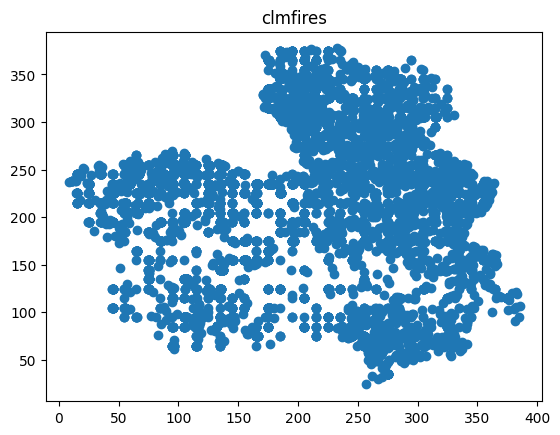

In [13]:
for k, tmp in data.items():
    fig, ax = plt.subplots()
    ax.scatter(tmp['x'], tmp['y'])
    ax.set_title(k)

Quadrat count analysis

In [29]:
k = 'clmfires'
tmp = data[k]
pts = list(zip(tmp['x'], tmp['y']))
#print(pts)
pp = PointPattern(pts)
#print(pp.summary())
#pp.plot(window= True, title= k)
q_r = qs.QStatistic(pp,shape= "rectangle", nx=5, ny=5)
q_r.plot()
print(q_r.mr.rectangle_width, q_r.mr.rectangle_height)
print(q_r.chi2) #chi-squared test statistic for the observed point pattern
print(q_r.df) #degree of freedom
print(q_r.chi2_pvalue) # analytical pvalue


/home/benny/.pyenv/versions/anaconda3-2022.10/lib/python3.9/site-packages/libpysal/cg/shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
/home/benny/.pyenv/versions/anaconda3-2022.10/lib/python3.9/site-packages/libpysal/cg/shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


75.41900164500001 70.59079716
4448.198162111215
24
0.0


For clmfires:  
Since the p-value based on the analytical distribution (degree of freedom = 24) is 0.0, much smaller than 0.05. We might determine that the underlying process is not CSR. 

In [30]:
k = 'clmfires'
tmp = data[k]    
pts = list(zip(tmp['x'], tmp['y']))
#print(pts)
pp = PointPattern(pts)
#print(pp.summary())
#pp.plot(window= True, title= k)
q_r = qs.QStatistic(pp,shape= "hexagon", lh=50)
q_r.plot()
#print(q_r.mr.rectangle_width, q_r.mr.rectangle_height)
print(q_r.chi2) #chi-squared test statistic for the observed point pattern
print(q_r.df) #degree of freedom
print(q_r.chi2_pvalue) # analytical pvalue


/home/benny/.pyenv/versions/anaconda3-2022.10/lib/python3.9/site-packages/libpysal/cg/shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
/home/benny/.pyenv/versions/anaconda3-2022.10/lib/python3.9/site-packages/libpysal/cg/shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


11043.145146088591
29
0.0


In [ ]:

#pp = PointPattern(pts)
#g_test = ripley.g_test(pts, support=10)
#l_test = ripley.l_test(pts, keep_simulations=True)
#l_test

## nearest neighbor analysis

0.010872185453339343

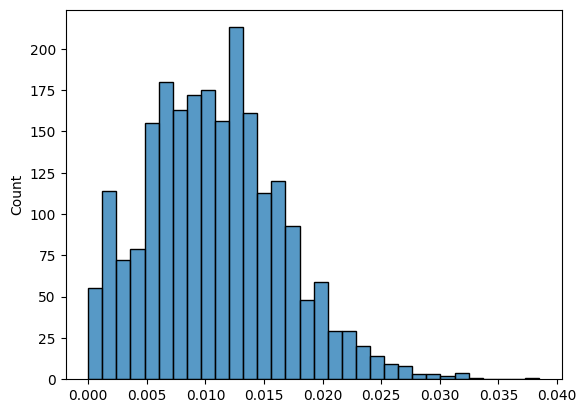

In [61]:
k = 'lansing'
tmp = data[k]
pts = list(zip(tmp['x'], tmp['y']))

# for monte carlo, need the coordinate range 
x0, x1 = min(tmp['x']), max(tmp['x'])
y0, y1 = min(tmp['y']), max(tmp['y'])
lx = x1 - x0
ly = y1 - y0

pts_tree = spatial.KDTree(pts)
distance, neighbors = pts_tree.query(pts, k=2)
distance = [d[1] for d in distance]
#neighbors = [n[1] for n in neighbors]
#distance
sns.histplot(distance)
observe_dist = np.mean(distance)
observe_dist

100%|██████████| 10000/10000 [00:29<00:00, 341.59it/s]


<Axes: ylabel='Count'>

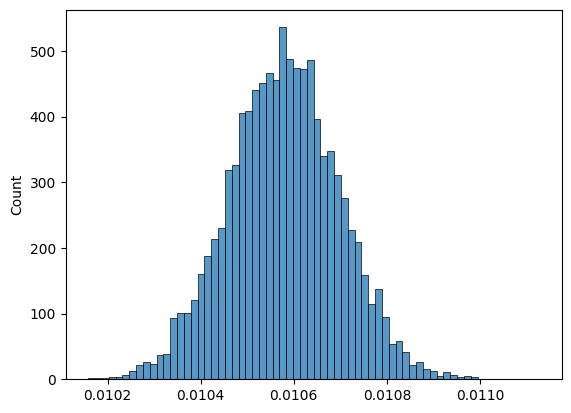

In [62]:
MC_dist = []
for _ in tqdm(range(10000)):
    ns = len(pts)
    rxs = []
    rys = []
    for i in range(ns):
        rx = random.random() * lx + x0
        ry = random.random() * ly + y0
        rxs.append(rx)
        rys.append(ry)
    r_pts = list(zip(rxs, rys))
    r_pts_tree = spatial.KDTree(r_pts)
    r_distance, neighbors = r_pts_tree.query(r_pts, k=2)
    r_distance = [d[1] for d in r_distance]
    sim_dist_mean = np.mean(r_distance)
    MC_dist.append(sim_dist_mean)
sns.histplot(MC_dist)

In [68]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(MC_dist, ax=ax)
ax.axvline(x=observe_dist, c='r')
upper = np.percentile(MC_dist, 97.5)  # 5%
lower = np.percentile(MC_dist, 2.5)  # 5%
ax.axvline(upper, ls='--', c='grey')
ax.axvline(lower, ls='--', c='grey')

for lansing:
The observed nearest neighbor mean value is higher than the 95% CI (upper bound). So we can say that it is not a CSR, and it is probably a dispersed pattern.

In [82]:
def cal_l_func(points, radius_list, area_size):
    tre = spatial.KDTree(points)
    lfuncs = []
    for r in radius_list:
        pairs = tre.query_pairs(r)
        l_val = np.sqrt((area_size * len(pairs)) / (np.pi * n*(n-1)))
        #print(r, len(pairs), l_val)
        lfuncs.append(l_val)
    return lfuncs


def gen_random(pts):
    ns = len(pts)
    # for monte carlo, need the coordinate range 
    x0, x1 = min(tmp['x']), max(tmp['x'])
    y0, y1 = min(tmp['y']), max(tmp['y'])
    lx = x1 - x0
    ly = y1 - y0

    rxs = []
    rys = []
    for i in range(ns):
        rx = random.random() * lx + x0
        ry = random.random() * ly + y0
        rxs.append(rx)
        rys.append(ry)
    r_pts = list(zip(rxs, rys))
    return r_pts

In [87]:
k = 'humberside'
tmp = data[k]
pts = list(zip(tmp['x'], tmp['y']))
n = len(pts)

# for monte carlo, need the coordinate range 
x0, x1 = min(tmp['x']), max(tmp['x'])
y0, y1 = min(tmp['y']), max(tmp['y'])
lx = x1 - x0
ly = y1 - y0
asize = lx*ly

min_l = min(lx, ly)
print(min_l, lx, ly)

n_sep = 10
l_sep = min_l / n_sep
rs = [r*l_sep for r in range(1, n_sep+1)]
#rs

lfs_obs = cal_l_func(pts, rs, asize)


476 611 476


In [88]:
MC_lfs = []
for _ in tqdm(range(100)):
    r_pts = gen_random(pts)
    lfs_r = cal_l_func(r_pts, rs, asize)
    MC_lfs.append(lfs_r)

100%|██████████| 100/100 [00:00<00:00, 108.68it/s]


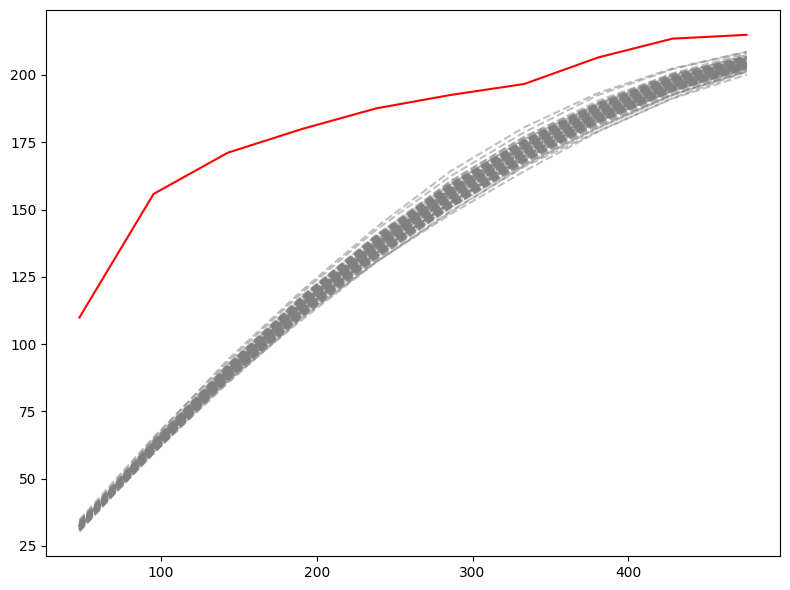

In [90]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(rs, lfs_obs, c='r')
for l_r in MC_lfs:
    ax.plot(rs, l_r, c='grey', ls='--', alpha=.5)
plt.tight_layout()

Fill in all the blanks in the Finding column, each blank 0.5 mark (4.5 mark in total). 

| Dataset    | Method     | Finding                                                             |
| ---------- | ---------- | ------------------------------------------------------------------- |
| clmfires   | Quadrat    | P-value <0.05, indicating not CSR, could be a clusered pattern      |
| clmfires   | NNA        |                                                                     |
| clmfires   | K-function |                                                                     |
| lansing    | Quadrat    |                                                                     |
| lansing    | NNA        | observed value > 95% CI, indicating a dispersed pattern             |
| lansing    | K-function |                                                                     |
| humberside | Quadrat    |                                                                     |
| humberside | NNA        |                                                                     |
| humberside | K-function | observed curve higher than simulation, indicating clustered pattern |
| cholera    | Quadrat    |                                                                     |
| cholera    | NNA        |                                                                     |
| cholera    | K-function |                                                                     |